In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import cv2
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

import utils
import eval
from train_utils import FallDataset, BalancedBatchSampler, Trainer, evaluate, KFoldCrossValidation

from model.stgcn import stgcn
from model.st_graph import get_distance_adjacency, get_uniform_adjacency, get_adjacency
from torch.utils.data import Dataset, DataLoader, Sampler
from sklearn.model_selection import train_test_split, KFold
from tqdm import tqdm
from matplotlib.animation import FuncAnimation
from matplotlib.collections import LineCollection






# ============ CONSTANTS ============ #

layer_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]
default_layer_config = [(64, 64, 1), (64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                        (128, 128, 1), (128, 256, 2), (256, 256, 1), (256, 256, 1)] # (in_channles, out_channels, temporal_stride)
my_config = [(64, 64, 1), (64, 64, 1), (64, 128, 2), (128, 128, 1),
                (128, 128, 1), (128, 256, 2), (256, 256, 1)]

edges = [
    [0, 1],  # Nose - Left Eye
    [0, 2],  # Nose - Right Eye
    [1, 3],  # Left Eye - Left Ear
    [2, 4],  # Right Eye - Right Ear
    [1, 5],  # Left Eye - Left Shoulder
    [2, 6],  # Right Eye - Right Shoulder
    [5, 7],  # Left Shoulder - Left Elbow
    [6, 8],  # Right Shoulder - Right Elbow
    [7, 9],  # Left Elbow - Left Wrist
    [8, 10],  # Right Elbow - Right Wrist
    [5, 11],  # Left Shoulder - Left Hip
    [6, 12],  # Right Shoulder - Right Hip
    [11, 13],  # Left Hip - Left Knee
    [12, 14],  # Right Hip - Right Knee
    [13, 15],  # Left Knee - Left Ankle
    [14, 16]   # Right Knee - Right Ankle
]

num_node = 17
A = get_uniform_adjacency(np.array(edges), num_node)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# Load data

In [4]:
LEC_ROOM_DIR = "D:\ASH\datasets\Le2i-skeleton\Lecture room\Skeletons_full_trim"
OFFICE_DIR = "D:\ASH\datasets\Le2i-skeleton\Office\Skeletons_full"

lec_room = eval.load_data(LEC_ROOM_DIR)
office = eval.load_data(OFFICE_DIR)

# dict_keys(['filename', 'keypoints', 'scores', 'boxes', 'offset', 'fall_interval'])
coffee_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\falls.npy", allow_pickle=True)
coffee_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Coffee room\Skeletons_full\\non_falls.npy", allow_pickle=True)
home_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\falls.npy", allow_pickle=True)
home_non_falls = np.load("D:\ASH\datasets\Le2i-skeleton\Home\Skeletons_full\\non_falls.npy", allow_pickle=True)

In [5]:
nframes = 45
shift_window = 0

falls = []
non_falls = []

candidates = ['office video (19)', 'office video (23)', 'office video (25)']
lec_room = [('lec_room ' + data[0], data[1], data[2]) for data in lec_room]
office = [('office ' + data[0], data[1], data[2]) for data in office]
temp_data = lec_room + office
temp_labels = eval.LEC_ROOM_LABELS + eval.OFFICE_LABELS
unseen_test_data = []
unseen_test_labels = []
temp = []
addons = []
for i, data in enumerate(temp_data):
    if data[0] not in candidates:
        unseen_test_data.append(data)
        unseen_test_labels.append(temp_labels[i])
    else:
        print(data[0])
        addons += utils.split_seq(data[1], 45, 0)[0]
non_falls += addons

print(f"Number of test videos: {len(unseen_test_data)}")

train_falls, train_non_falls = utils.split_skeletons(coffee_falls, nframes=nframes, shift_window=shift_window)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(coffee_non_falls, nframes=nframes, shift_window=shift_window)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(home_falls, nframes=nframes, shift_window=shift_window)
falls += train_falls
non_falls += train_non_falls

train_falls, train_non_falls = utils.split_skeletons(home_non_falls, nframes=nframes, shift_window=shift_window)
falls += train_falls
non_falls += train_non_falls

falls = np.array(falls)
non_falls = np.array(non_falls)

X_falls = falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates
X_non_falls = non_falls[:, :, :, :2].astype(np.float32) # remove the scores only keep the coordinates

# X_falls = falls.astype(np.float32) # remove the scores only keep the coordinates
# X_non_falls = non_falls.astype(np.float32) # remove the scores only keep the coordinates

print(X_falls.shape, X_non_falls.shape)

max_x = 320
max_y = 240

X_falls[:, :, :, 0] /= max_x
X_falls[:, :, :, 1] /= max_y
X_non_falls[:, :, :, 0] /= max_x
X_non_falls[:, :, :, 1] /= max_y
X_falls = np.transpose(X_falls, (0, 3, 1, 2))
X_non_falls = np.transpose(X_non_falls, (0, 3, 1, 2))
print(X_falls.shape, X_non_falls.shape)

office video (19)
office video (23)
office video (25)
Number of test videos: 57
(99, 45, 17, 2) (933, 45, 17, 2)
(99, 2, 45, 17) (933, 2, 45, 17)


Fold 0:


Training Loss: 0.3436: 100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Training loss: 0.3435528549642274
Validation loss: 0.3278786636493056
Training accuracy: 0.9696969696969697
Validation accuracy: 0.9855072463768116


100%|██████████| 57/57 [00:19<00:00,  2.95it/s]


True positives: ['lec_room video (1)', 'lec_room video (3)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (12)', 'lec_room video (13)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (8)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (31)', 'office video (32)', 'office video (33)']
False positives: ['lec_room video (17)', 'lec_room video (19

Training Loss: 0.3383: 100%|██████████| 35/35 [00:28<00:00,  1.21it/s]


Training loss: 0.3383465577616836
Validation loss: 0.36635837721939823
Training accuracy: 0.9757575757575757
Validation accuracy: 0.9468599033816425


100%|██████████| 57/57 [00:19<00:00,  2.98it/s]


True positives: ['lec_room video (1)', 'lec_room video (3)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (

Training Loss: 0.3478: 100%|██████████| 35/35 [00:28<00:00,  1.22it/s]


Training loss: 0.34777104540304704
Validation loss: 0.3482151706725503
Training accuracy: 0.9648484848484848
Validation accuracy: 0.966183574879227


100%|██████████| 57/57 [00:19<00:00,  2.87it/s]


True positives: ['lec_room video (1)', 'lec_room video (3)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (18)', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (31)', 'office video (32)', 'office video (33)']
False positives: ['lec_room video (16) trim

Training Loss: 0.4088: 100%|██████████| 35/35 [00:28<00:00,  1.24it/s]


Training loss: 0.408843948895937
Validation loss: 0.4100759466296261
Training accuracy: 0.9043583535108959
Validation accuracy: 0.9029126213592233


100%|██████████| 57/57 [00:19<00:00,  2.99it/s]


True positives: []
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (17)', 'lec_room video (18)', 'lec_room video (19)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (23)', 'lec_room video (24)', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (31)', 'office video (32)', 'office video (33)']
False positives: []
False negatives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1

Training Loss: 0.3429: 100%|██████████| 35/35 [00:28<00:00,  1.23it/s]


Training loss: 0.3429108178457009
Validation loss: 0.34277218144114424
Training accuracy: 0.969770253929867
Validation accuracy: 0.9707317073170731


100%|██████████| 57/57 [00:19<00:00,  2.98it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (12)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (20)', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (31)', 'office video (32)', 'office video (33)']
False positives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (17)', 'lec_room video (18)',

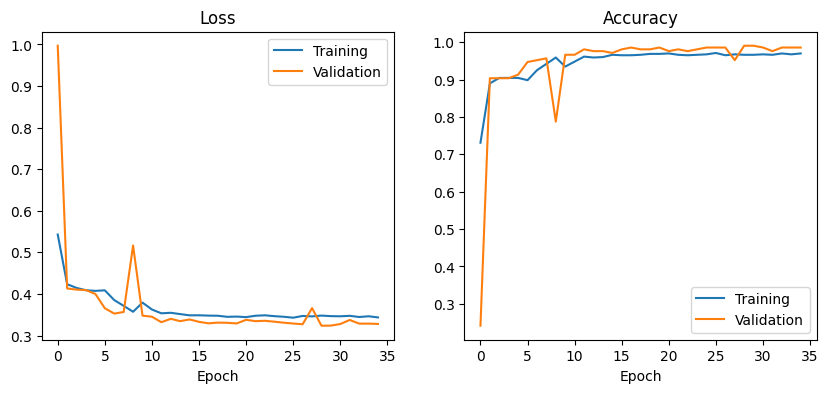

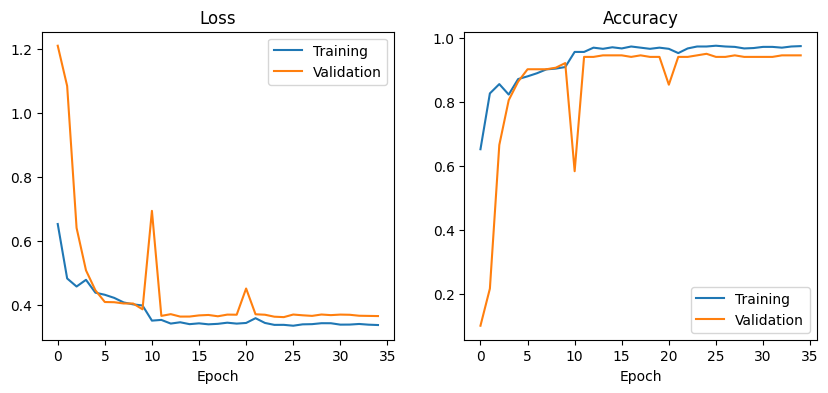

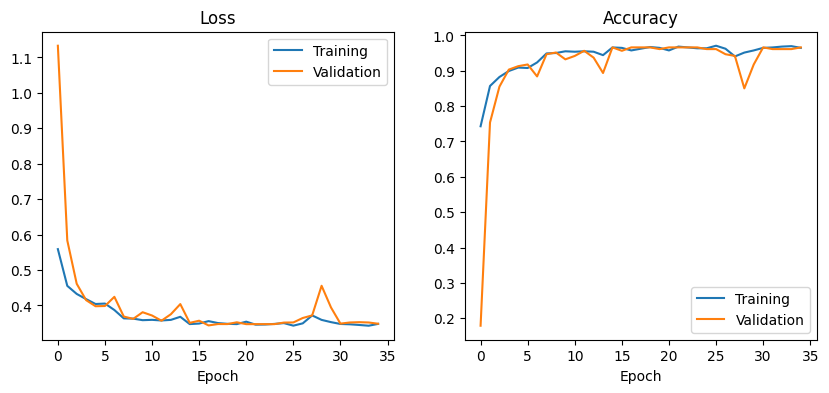

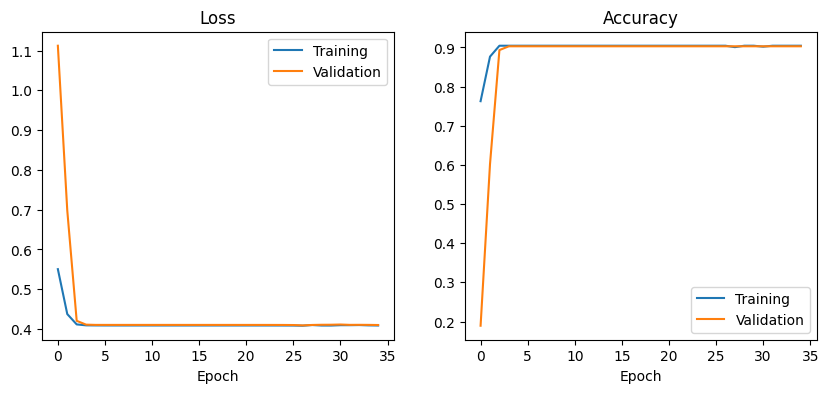

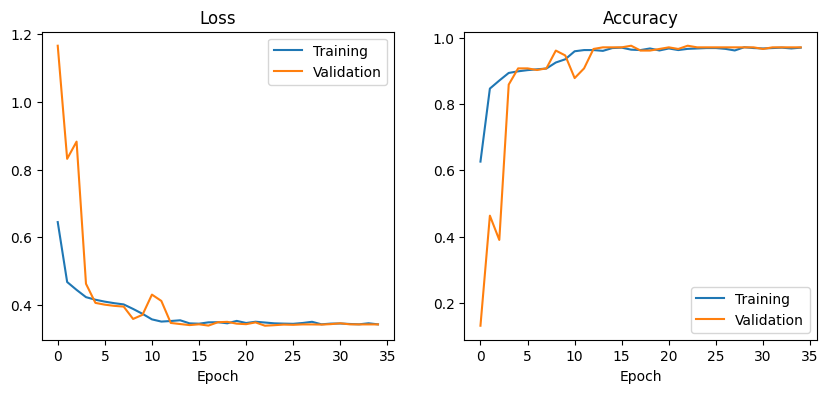

In [100]:
# learnable_mask = False and no batch-balanced sampling
epochs_1 = 35
lr_1 = 1e-3
weight_decay_1 = 0
batch_size_1 = 128
shift_window_size_1 = None
learnable_mask_1 = False

KFoldCrossValidation(stgcn, 5, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr_1, batch_size_1, epochs_1, weight_decay_1, False, shift_window_size=shift_window_size_1, 
                     num_class=2, window_size=45, num_point=17, in_channels=2, graph=A, layer_config=default_layer_config, learnable_mask=learnable_mask_1)

Fold 0:


Training Loss: 0.3638: 100%|██████████| 35/35 [00:53<00:00,  1.54s/it]


Training loss: 0.36384534897903603
Validation loss: 0.35820890610344747
Training accuracy: 0.9505208333333334
Validation accuracy: 0.9516908212560387


100%|██████████| 57/57 [00:19<00:00,  2.95it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (11)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office vide

Training Loss: 0.3579: 100%|██████████| 35/35 [00:53<00:00,  1.54s/it]


Training loss: 0.35790476490122575
Validation loss: 0.3473779379169722
Training accuracy: 0.9537760416666666
Validation accuracy: 0.966183574879227


100%|██████████| 57/57 [00:19<00:00,  2.89it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (8)', 'office video (13)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (31)', 'office video (32)', 'office video (33)']
False positives:

Training Loss: 0.3494: 100%|██████████| 35/35 [00:54<00:00,  1.56s/it]


Training loss: 0.3494005841591085
Validation loss: 0.350029402596939
Training accuracy: 0.9641927083333334
Validation accuracy: 0.966183574879227


100%|██████████| 57/57 [00:19<00:00,  2.98it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (16) trim', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (20)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (32)', 'office video (33)

Training Loss: 0.3360: 100%|██████████| 35/35 [00:54<00:00,  1.56s/it]


Training loss: 0.3360241276339889
Validation loss: 0.34259101545926435
Training accuracy: 0.9772283669486012
Validation accuracy: 0.970873786407767


100%|██████████| 57/57 [00:19<00:00,  2.97it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (19)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video 

Training Loss: 0.3404: 100%|██████████| 35/35 [00:53<00:00,  1.52s/it]


Training loss: 0.34040923669943907
Validation loss: 0.3543667149253008
Training accuracy: 0.9728506787330317
Validation accuracy: 0.9609756097560975


100%|██████████| 57/57 [00:19<00:00,  2.98it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (16) trim', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (22)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (32)', 'office video (33)

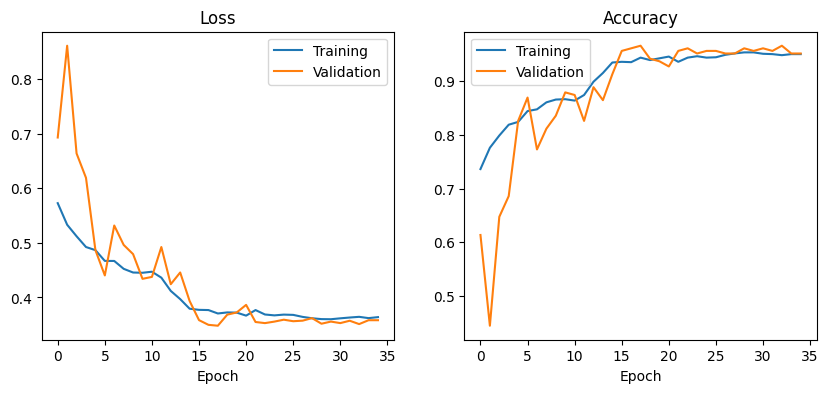

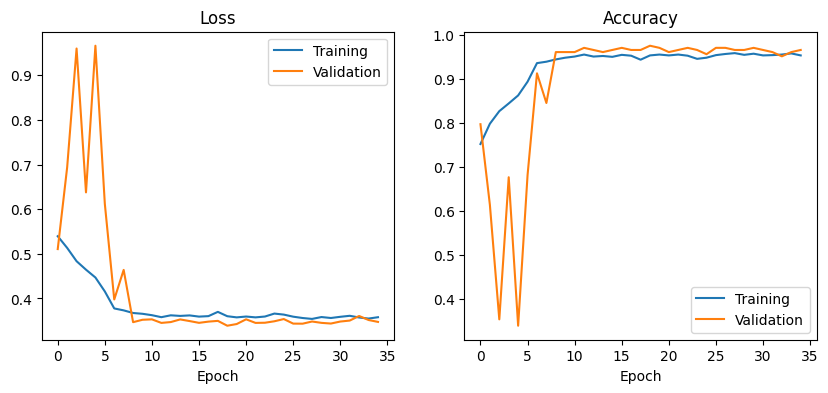

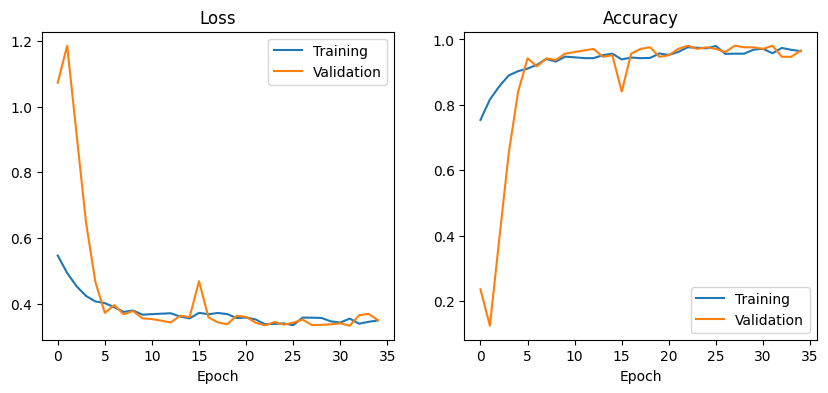

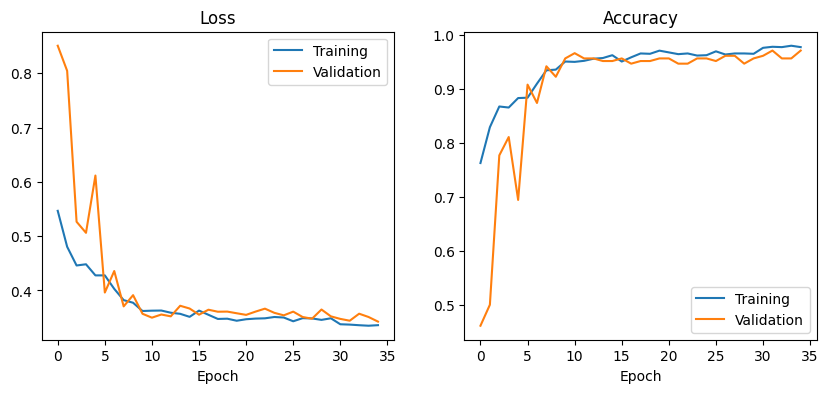

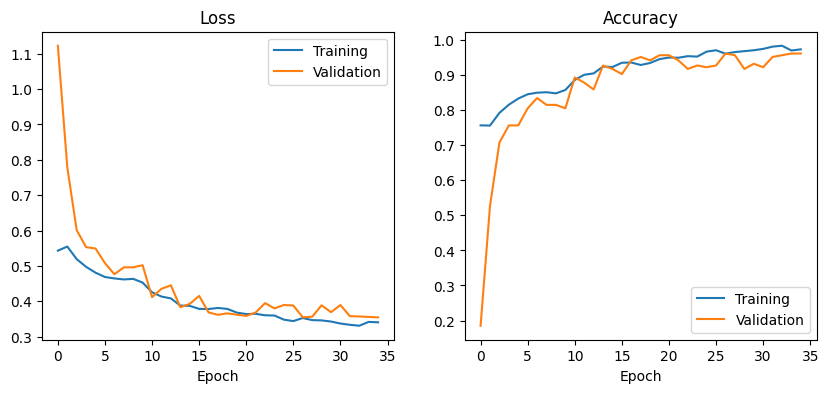

In [93]:
# learnable_mask = False
epochs_1 = 35
lr_1 = 1e-3
weight_decay_1 = 0
batch_size_1 = 128
shift_window_size_1 = None
learnable_mask_1 = False

KFoldCrossValidation(stgcn, 5, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr_1, batch_size_1, epochs_1, weight_decay_1, False, shift_window_size=shift_window_size_1, 
                     num_class=2, window_size=45, num_point=17, in_channels=2, graph=A, layer_config=default_layer_config, learnable_mask=learnable_mask_1)

Fold 0:


Training Loss: 0.3437: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Training loss: 0.3437363857572729
Validation loss: 0.34975125565045123
Training accuracy: 0.9696969696969697
Validation accuracy: 0.961352657004831


100%|██████████| 57/57 [00:19<00:00,  2.93it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (17)', 'lec_room video (18)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video (26)', 'office vi

Training Loss: 0.4090: 100%|██████████| 35/35 [00:29<00:00,  1.20it/s]


Training loss: 0.40902544747699393
Validation loss: 0.4098856971747633
Training accuracy: 0.9042424242424243
Validation accuracy: 0.9033816425120773


100%|██████████| 57/57 [00:20<00:00,  2.84it/s]


True positives: []
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (17)', 'lec_room video (18)', 'lec_room video (19)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (23)', 'lec_room video (24)', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (31)', 'office video (32)', 'office video (33)']
False positives: []
False negatives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1

Training Loss: 0.3416: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Training loss: 0.3416344345338417
Validation loss: 0.3447096866110097
Training accuracy: 0.9721212121212122
Validation accuracy: 0.9710144927536232


100%|██████████| 57/57 [00:19<00:00,  2.97it/s]


True positives: ['lec_room video (1)', 'lec_room video (3)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (

Training Loss: 0.3400: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Training loss: 0.33999443075847396
Validation loss: 0.3521619809484019
Training accuracy: 0.9733656174334141
Validation accuracy: 0.9611650485436893


100%|██████████| 57/57 [00:19<00:00,  2.86it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (11)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (24)', 'office video (26)', 'office video (27)', 'office vide

Training Loss: 0.3443: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]


Training loss: 0.3443201186434966
Validation loss: 0.33277344790900626
Training accuracy: 0.9685610640870617
Validation accuracy: 0.9804878048780488


100%|██████████| 57/57 [00:19<00:00,  2.99it/s]


True positives: ['lec_room video (1)', 'lec_room video (3)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (30)', 'office video (31

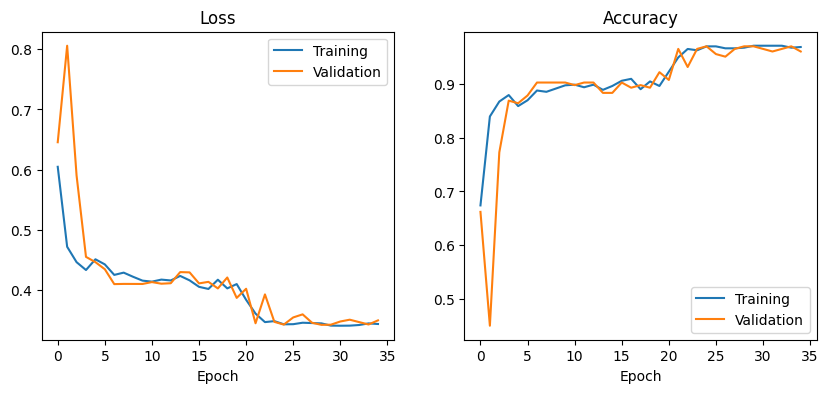

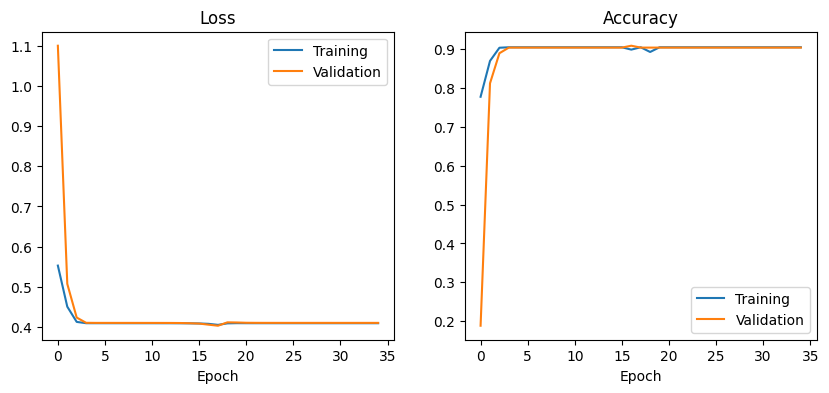

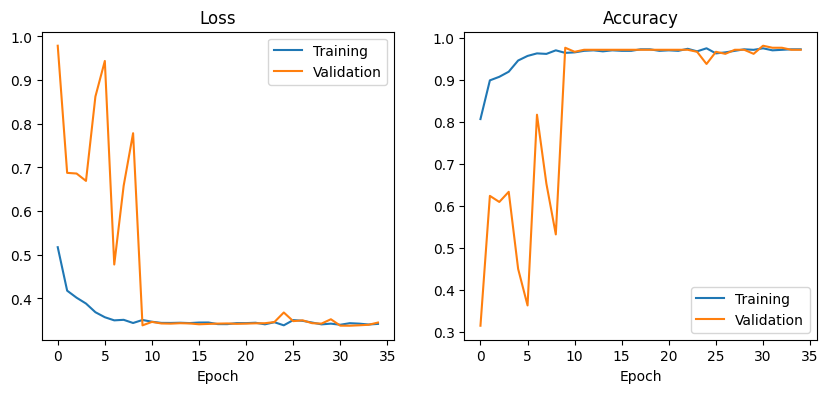

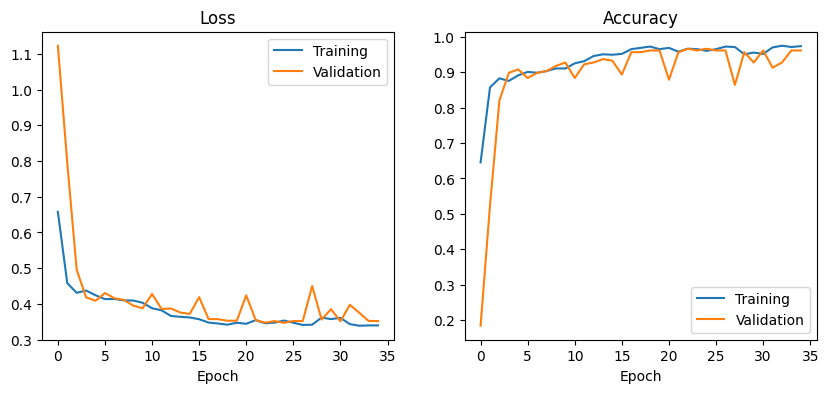

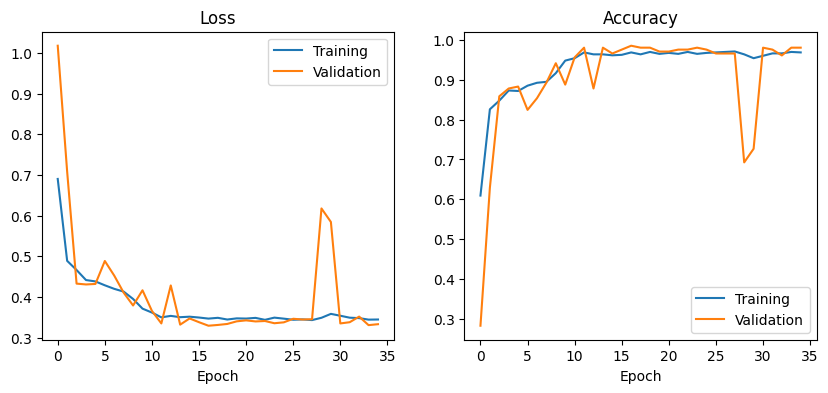

In [92]:
# no batch balanced sampling
epochs_1 = 35
lr_1 = 1e-3
weight_decay_1 = 0
batch_size_1 = 128
shift_window_size_1 = None
learnable_mask_1 = True

KFoldCrossValidation(stgcn, 5, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr_1, batch_size_1, epochs_1, weight_decay_1, False, shift_window_size=shift_window_size_1, 
                     num_class=2, window_size=45, num_point=17, in_channels=2, graph=A, layer_config=default_layer_config, learnable_mask=learnable_mask_1)

Fold 0:


Training Loss: 0.3311: 100%|██████████| 35/35 [00:55<00:00,  1.60s/it]


Training loss: 0.3310923319077119
Validation loss: 0.35413814742783994
Training accuracy: 0.9830729166666666
Validation accuracy: 0.9565217391304348


100%|██████████| 57/57 [00:19<00:00,  2.97it/s]


True positives: ['lec_room video (1)', 'lec_room video (3)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (11)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (17)', 'lec_room video (18)', 'lec_room video (19)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (26)', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video (26)', 'office video (27)', 'office vide

Training Loss: 0.3257: 100%|██████████| 35/35 [00:55<00:00,  1.58s/it]


Training loss: 0.32567945196448517
Validation loss: 0.3711296330039628
Training accuracy: 0.9876302083333334
Validation accuracy: 0.9371980676328503


100%|██████████| 57/57 [00:19<00:00,  2.94it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (19)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video (26)', 'office video

Training Loss: 0.3312: 100%|██████████| 35/35 [00:55<00:00,  1.58s/it]


Training loss: 0.33122443248673034
Validation loss: 0.3426382957737227
Training accuracy: 0.982421875
Validation accuracy: 0.9710144927536232


100%|██████████| 57/57 [00:19<00:00,  2.96it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (18)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (18)', 'office video (21)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (31)', 'office video (32

Training Loss: 0.3317: 100%|██████████| 35/35 [00:55<00:00,  1.58s/it]


Training loss: 0.331741170578369
Validation loss: 0.3522497435796608
Training accuracy: 0.9817826935588809
Validation accuracy: 0.9611650485436893


100%|██████████| 57/57 [00:19<00:00,  2.95it/s]


True positives: ['lec_room video (1)', 'lec_room video (2)', 'lec_room video (3)', 'lec_room video (4)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (8)', 'lec_room video (9)', 'lec_room video (10)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'lec_room video (14)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (11)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (16) trim', 'lec_room video (19)', 'lec_room video (20)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (22)', 'office video (24)', 'office video 

Training Loss: 0.3287: 100%|██████████| 35/35 [00:54<00:00,  1.55s/it]


Training loss: 0.32870085573073116
Validation loss: 0.351537920934398
Training accuracy: 0.9857789269553976
Validation accuracy: 0.9658536585365853


100%|██████████| 57/57 [00:19<00:00,  2.97it/s]


True positives: ['lec_room video (1)', 'lec_room video (3)', 'lec_room video (5)', 'lec_room video (6)', 'lec_room video (7)', 'lec_room video (9)', 'lec_room video (11)', 'lec_room video (12)', 'lec_room video (13)', 'office video (1)', 'office video (2)', 'office video (3)', 'office video (4)', 'office video (5)', 'office video (6)', 'office video (7)', 'office video (8)', 'office video (9)', 'office video (10)', 'office video (12)', 'office video (13)', 'office video (14)', 'office video (15)', 'office video (16)', 'office video (17)']
True negatives: ['lec_room video (15)', 'lec_room video (16) trim', 'lec_room video (17)', 'lec_room video (18)', 'lec_room video (21) trim', 'lec_room video (22) trim', 'lec_room video (25) trim', 'lec_room video (27) trim', 'office video (18)', 'office video (20)', 'office video (21)', 'office video (24)', 'office video (26)', 'office video (27)', 'office video (28)', 'office video (29)', 'office video (31)', 'office video (32)', 'office video (33)'

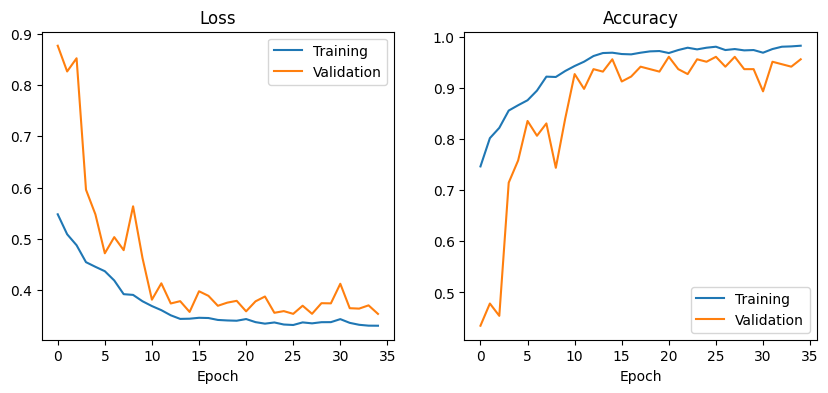

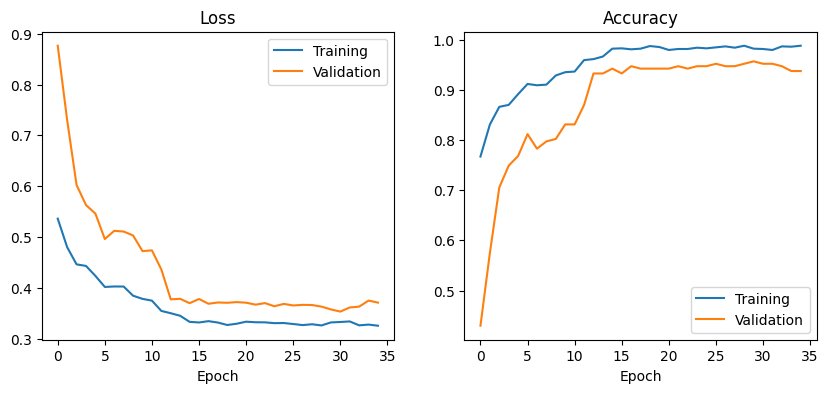

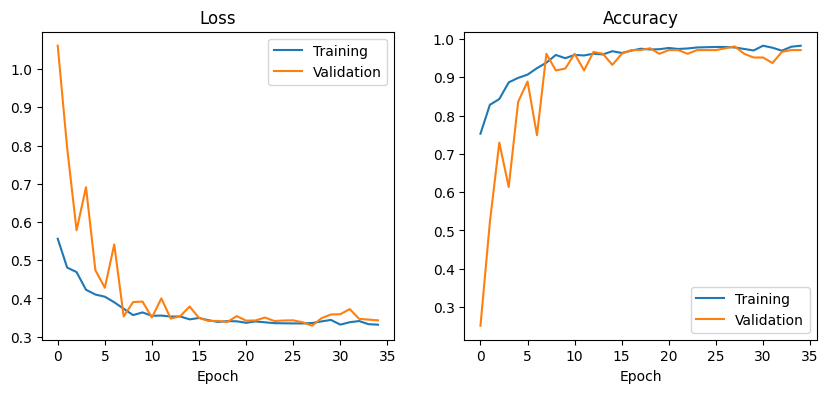

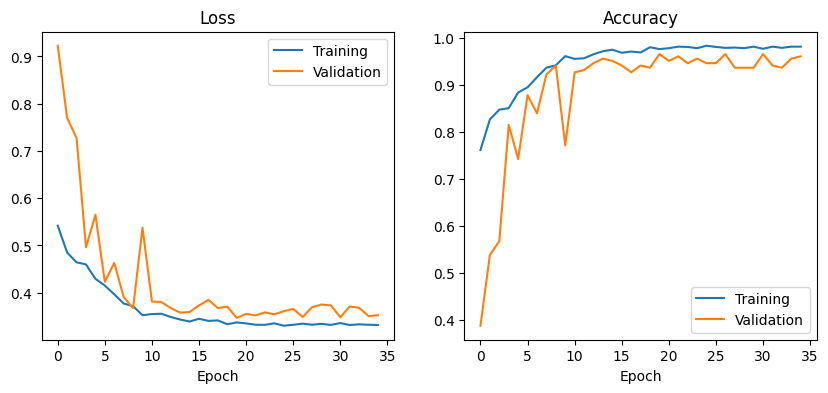

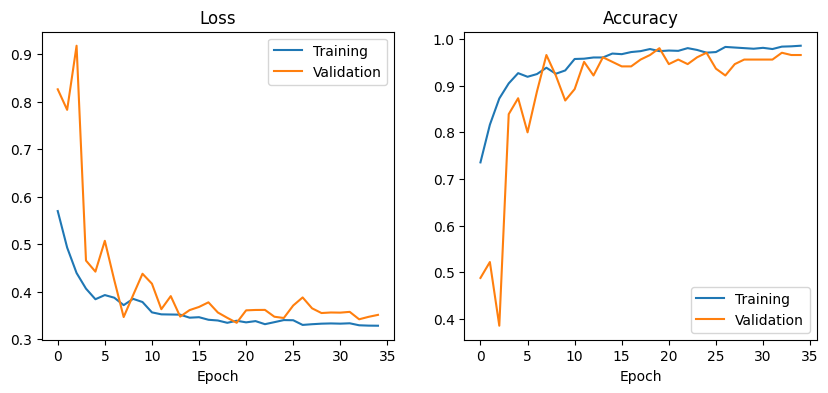

In [104]:
# learnable_mask = True and batch balanced sampleing
epochs_1 = 35
lr_1 = 1e-3
weight_decay_1 = 0
batch_size_1 = 128
shift_window_size_1 = None
learnable_mask_1 = True

KFoldCrossValidation(stgcn, 5, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr_1, batch_size_1, epochs_1, weight_decay_1, False, shift_window_size=shift_window_size_1, 
                     num_class=2, window_size=45, num_point=17, in_channels=2, graph=A, layer_config=default_layer_config, learnable_mask=learnable_mask_1)

# 5-Fold-Validation

In [ ]:
print("Start running 5-Fold_Validation for model comparison\n\n\n")

print("======================Model 1====================== \n")
KFoldCrossValidation(stgcn, 5, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr_1, batch_size_1, epochs_1, weight_decay_1, False, shift_window_size=shift_window_size_1, 
                     num_class=2, window_size=45, num_point=17, in_channels=2, graph=A, layer_config=default_layer_config, learnable_mask=learnable_mask_1)

print("=================================================== \n")

print("======================Model 2====================== \n")
KFoldCrossValidation(stgcn, 5, X_falls, X_non_falls, unseen_test_data, unseen_test_labels, 'adam', lr_2, batch_size_2, epochs_2, weight_decay_2, False, shift_window_size=shift_window_size_2, 
                     num_class=2, window_size=45, num_point=17, in_channels=2, graph=A, layer_config=default_layer_config, learnable_mask=learnable_mask_2)

# Visualize Edge Connections

In [7]:
falls_train, falls_valid = train_test_split(X_falls, test_size=0.2)
non_falls_train, non_falls_valid = train_test_split(X_non_falls, test_size=len(falls_valid))
training_set = FallDataset(falls=falls_train, non_falls=non_falls_train, window_size=45)
validation_set = FallDataset(falls=falls_valid, non_falls=non_falls_valid, window_size=45, valid=True)

Training Loss: 0.3262: 100%|██████████| 35/35 [01:04<00:00,  1.85s/it]


Training loss: 0.3262100780541893
Validation loss: 0.37195417284965515
Training accuracy: 0.9865663621708759
Validation accuracy: 0.95


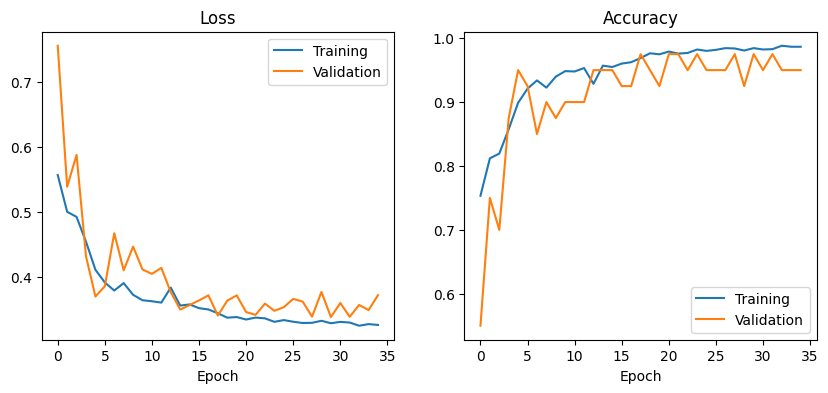

In [8]:
model = None
model = stgcn(num_class=2, window_size=45, num_point=17, graph=A, layer_config=default_layer_config, learnable_mask=True)
model.to(device)

epochs = 35
lr = 1e-3
weight_decay = 0
batch_size = 128
loss_func = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
training_loader = torch.utils.data.DataLoader(training_set, batch_sampler=BalancedBatchSampler(training_set))
validation_loader = torch.utils.data.DataLoader(validation_set, batch_size=128, shuffle=False)

train_loss_list, train_acc_list = [], []
val_loss_list, val_acc_list = [], []

progress = tqdm(np.arange(epochs))
for n in progress:
    model.train()
    running_loss = 0
    running_acc = 0
    count = 0
    for X_batch, y_batch in training_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.type(torch.LongTensor).to(device)

        y_pred = model(X_batch)
        batch_loss = loss_func(y_pred, y_batch)
        running_loss += batch_loss.item() * X_batch.size(0)
        running_acc += torch.sum(torch.argmax(y_pred, axis=-1) == y_batch).detach().cpu().item()

        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
        count += X_batch.size(0)

    train_loss = running_loss / count
    train_acc = running_acc / count
    train_loss_list.append(train_loss)
    train_acc_list.append(train_acc)

    val_loss, val_acc = evaluate(model, validation_loader)
    val_loss_list.append(val_loss)
    val_acc_list.append(val_acc)
    
    progress.set_description(f'Training Loss: {train_loss:.4f}')

x_axis = np.arange(epochs)
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
axes[0].plot(x_axis, train_loss_list, label="Training")
axes[0].plot(x_axis, val_loss_list, label="Validation")
axes[0].set_title("Loss")
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[1].plot(x_axis, train_acc_list, label='Training')
axes[1].plot(x_axis, val_acc_list, label='Validation')
axes[1].set_title("Accuracy")
axes[1].set_xlabel('Epoch')
axes[1].legend()

print(f"Training loss: {train_loss_list[-1]}")
print(f"Validation loss: {val_loss_list[-1]}")
print(f"Training accuracy: {train_acc_list[-1]}")
print(f"Validation accuracy: {val_acc_list[-1]}")

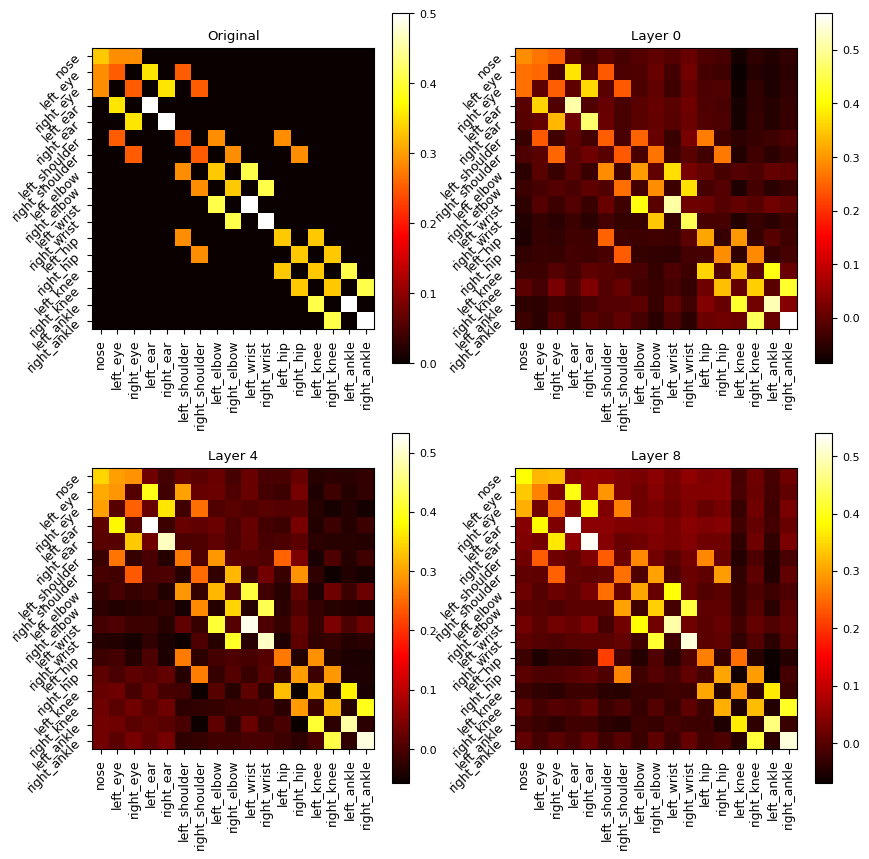

In [143]:
coco_keypoints = [
    "nose", "left_eye", "right_eye", 
    "left_ear", "right_ear", 
    "left_shoulder", "right_shoulder", 
    "left_elbow", "right_elbow", 
    "left_wrist", "right_wrist", 
    "left_hip", "right_hip", 
    "left_knee", "right_knee", 
    "left_ankle", "right_ankle"
]


fig, ax = plt.subplots(2, 2, figsize=(10, 10))

plt.rcParams.update({'font.size': 8})

im = ax[0][0].imshow(A[0], cmap='hot', interpolation='nearest')
ax[0][0].set_title('Original')
ax[0][0].set_xticks(range(len(coco_keypoints)))
ax[0][0].set_xticklabels(coco_keypoints, rotation=90)
ax[0][0].set_yticks(range(len(coco_keypoints)))
ax[0][0].set_yticklabels(coco_keypoints, rotation=45)
fig.colorbar(im, ax=ax[0][0])

im = ax[0][1].imshow((model.layers[0].sgcn.mask * model.layers[0].sgcn.A[0] + model.layers[0].sgcn.mask_bias)[0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
ax[0][1].set_title('Layer 0')
ax[0][1].set_xticks(range(len(coco_keypoints)))
ax[0][1].set_xticklabels(coco_keypoints, rotation=90)
ax[0][1].set_yticks(range(len(coco_keypoints)))
ax[0][1].set_yticklabels(coco_keypoints, rotation=45)
fig.colorbar(im, ax=ax[0][1])

im = ax[1][0].imshow((model.layers[4].sgcn.mask * model.layers[4].sgcn.A[0] + model.layers[4].sgcn.mask_bias)[0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
ax[1][0].set_title('Layer 4')
ax[1][0].set_xticks(range(len(coco_keypoints)))
ax[1][0].set_xticklabels(coco_keypoints, rotation=90)
ax[1][0].set_yticks(range(len(coco_keypoints)))
ax[1][0].set_yticklabels(coco_keypoints, rotation=45)
fig.colorbar(im, ax=ax[1][0])

im = ax[1][1].imshow((model.layers[8].sgcn.mask * model.layers[8].sgcn.A[0] + model.layers[8].sgcn.mask_bias)[0].cpu().detach().numpy(), cmap='hot', interpolation='nearest')
ax[1][1].set_title('Layer 8')
ax[1][1].set_xticks(range(len(coco_keypoints)))
ax[1][1].set_xticklabels(coco_keypoints, rotation=90)
ax[1][1].set_yticks(range(len(coco_keypoints)))
ax[1][1].set_yticklabels(coco_keypoints, rotation=45)
fig.colorbar(im, ax=ax[1][1])

plt.show()

In [11]:
filename, skeletons, frame_ids = unseen_test_data[23]
print(filename)
batch = eval.create_batch(skeletons)
model.eval()
with torch.no_grad():
    batch_tensor = torch.tensor(batch).to(device)
    pred = model(batch_tensor).cpu()
results = torch.argmax(pred, axis=-1).numpy()

lec_room video (24)


In [13]:
# This is an example, replace it with your video path
video_path = "D:\ASH\datasets\Le2i\Lecture room\Videos\\video (24).avi"
cap = cv2.VideoCapture(video_path)

output_video_path = 'output_video.avi'  # Path to save the output video
frame_width = 320  # Width of the frames in the video
frame_height = 240  # Height of the frames in the video
fps = 25  # Frames per second
fourcc = cv2.VideoWriter_fourcc(*'XVID')  # Specify the codec
out = cv2.VideoWriter(output_video_path, fourcc, fps, (frame_width, frame_height))

frame_ptr = 0
curr_frame = 0
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break
    
    position = (10, 10)  # Coordinates of the upper left corner
    font = cv2.FONT_HERSHEY_SIMPLEX
    font_scale = 0.5
    font_color = (255, 255, 255)
    text = "N/A"
    
    if frame_ptr < len(frame_ids) and frame_ids[frame_ptr] == curr_frame:
        pred_idx = frame_ptr - 45 + 1
        if pred_idx >= 0 and pred_idx < len(results):
            pred = results[pred_idx]
            if pred == 1:
                text = "Fall"
                font_color = (0, 0, 255)
            else:
                text = "No fall"
                font_color = (0, 255, 0)
            
        # Example joint coordinates for one person in the frame
        # Replace this with your actual detection data
        # Format: [x, y, confidence]
        joints = skeletons[frame_ptr]
        
        # Draw joints
        for joint in joints:
            # Convert coordinates to integers
            x, y = int(joint[0]), int(joint[1])
            cv2.circle(frame, (x, y), 4, (0, 0, 255), -1)
        
        # Draw skeleton
        for bone in edges:
            # Convert coordinates to integers
            start_point, end_point = joints[bone[0]], joints[bone[1]]
            start_point = (int(start_point[0]), int(start_point[1]))
            end_point = (int(end_point[0]), int(end_point[1]))
            cv2.line(frame, start_point, end_point, (255, 0, 0), 2)
        
        frame_ptr += 1
    
    cv2.putText(frame, text, position, font, font_scale, font_color, thickness=2)

    # Display the frame with drawn joints and connections
    cv2.imshow('Frame', frame)
    out.write(frame)
    
    # if frame_ptr >= len(results): break 
    
    if cv2.waitKey(25) & 0xFF == ord('q'):
        break
    
    curr_frame += 1

# Release everything if job is finished
out.release()
cap.release()
cv2.destroyAllWindows()